In [795]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [796]:
pattern_size = (9, 6) # width, height
s = 1
image_size = (480 // 2, 640 // 2)
border_width = 40 // 2
square_size = 50 // 2

pattern_image = np.ones(image_size, np.uint8)
pattern_corners = np.zeros(((pattern_size[0]) * (pattern_size[1]), 2), np.float32)
n = 0
for j in range(pattern_size[1] + 1):
    y = border_width + j * square_size
    for i in range(pattern_size[0] + 1):
        x = border_width + i * square_size

        if (i + j) % 2 == 0:
            pattern_image[y:y + square_size, x:x + square_size] = 0

        if 0 < i <= pattern_size[0] and 0 < j <= pattern_size[1]:
            pattern_corners[n, 0] = x - 0.5
            pattern_corners[n, 1] = y - 0.5
            n += 1


In [797]:
def noisy(noise_typ, image):
    if noise_typ == "gauss":
        row, col = image.shape
        mean = 0
        var = 0.00001
        sigma = var ** 0.5
        gauss = np.random.normal(mean, sigma, (row, col))
        gauss = gauss.reshape(row, col)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row, col = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount * image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in image.shape]
        out[coords] = 0
        return out

    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ == "speckle":
        row, col, ch = image.shape
        gauss = np.random.randn(row, col, ch)
        gauss = gauss.reshape(row, col, ch)
        noisy = image + image * gauss
    return noisy

In [798]:
pattern_image = noisy('poisson', pattern_image)

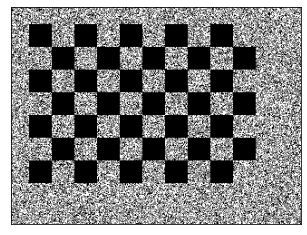

In [799]:
pattern_image = (255 * pattern_image).astype(np.uint8)
plt.imshow(pattern_image, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()


In [800]:
status, corners = cv.findChessboardCorners(pattern_image, pattern_size)
if status:
    #print(corners)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 300, 0.01)
    cv.cornerSubPix(pattern_image, corners, (5, 5), (-1, -1), criteria)
else:
    print("Could not detect corners")

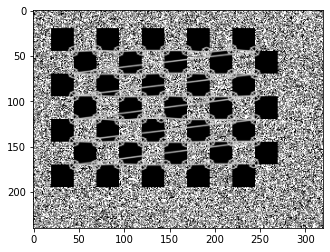

In [801]:
cv.drawChessboardCorners(pattern_image, (9, 6), corners, status)
plt.imshow(pattern_image, cmap='gray')
plt.show()

In [802]:
corners = corners.reshape(-1, 2)
print(corners.shape)
print(pattern_corners.shape)

diff = corners - pattern_corners
print(np.mean(diff, axis=1))


(54, 2)
(54, 2)
[ 1.0268021e-01  2.1349144e-01 -2.9790878e-01 -4.5420456e-01
 -2.7115440e-01 -5.0377274e-01 -7.1749115e-01 -8.7581062e-01
  1.4504623e-01 -6.2858582e-02 -6.6179276e-01  2.7027893e-01
 -2.9131699e-01 -4.3241882e-01 -5.8784485e-03  1.2714005e-01
  3.0788422e-02  4.4605255e-01  2.7003479e-01 -2.8865814e-01
  4.7293091e-01  3.4654236e-01 -1.1500168e-01  3.8479614e-01
  2.6538086e-01  2.0706177e-01 -7.0545197e-02  2.5125504e-02
  1.2578964e-01  9.7495270e-01  4.4803619e-02 -2.5610847e+00
  3.0090332e-02  5.6809235e-01  3.7166595e-02  7.7360916e-01
  1.8777847e-02  1.8574142e-01 -8.8787079e-02  4.1029358e-01
 -1.4078522e-01 -2.8881073e-01  2.4719238e-03 -8.4182739e-02
  7.9963684e-02  8.3097458e-02  1.7684555e-01 -5.4362106e-01
  5.1280212e-01  9.8171234e-01  2.7147675e-01 -4.5084381e-01
 -1.5838623e-01 -1.5221176e+00]


0.8193302


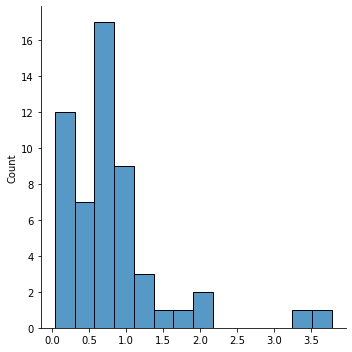

In [803]:
errors = np.linalg.norm(diff, axis=1)
sns.displot(errors)
print(np.mean(errors))